# Rabbits and foxes

There are initially 400 rabbits and 200 foxes on a farm (but it could be two cell types in a 96 well plate or something, if you prefer bio-engineering analogies). Plot the concentration of foxes and rabbits as a function of time for a period of up to 600 days. The predator-prey relationships are given by the following set of coupled ordinary differential equations:

\begin{align}
\frac{dR}{dt} &= k_1 R - k_2 R F \tag{1}\\
\frac{dF}{dt} &= k_3 R F - k_4 F \tag{2}\\
\end{align}

* Constant for growth of rabbits $k_1 = 0.015$ day<sup>-1</sup>
* Constant for death of rabbits being eaten by foxes $k_2 = 0.00004$ day<sup>-1</sup> foxes<sup>-1</sup>
* Constant for growth of foxes after eating rabbits $k_3 = 0.0004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* Constant for death of foxes $k_4 = 0.04$ day<sup>-1</sup>

*This problem is based on one from Chapter 1 of H. Scott Fogler's textbook "Essentials of Chemical Reaction Engineering".*


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.stats import iqr

# Now let's try some Kinetic Monte Carlo

We wish to implement a Kinetic Monte Carlo algorithm to simulate the same situation. See https://en.wikipedia.org/wiki/Kinetic_Monte_Carlo for details.

We'll assume the numbers of rabbits and foxes (starting at 400 and 200) are actual rabbits and foxes, not "rabbit densities" for example, and so must always remain integers: you can't have half a rabbit or half a fox.

There are four events, with rates that are straightforward to calculate, so the rejection-free algorithm is suitable:
* `rabbit_birth = k1 * rabbits`
* `rabbit_death = k2 * rabbits * foxes`
* `fox_birth = k3 * rabbits * foxes`
* `fox_death = k4 * foxes`


Use a Kinetic Monte Carlo simulation(s) running for 600 days to determine
1. The expected location of the second peak in foxes (eg. 425 days, 2800 foxes), on occasions that there is one (eg. if there's a peak that's  >200 days and >100 foxes)
2. The interquartile range of the second peak in foxes (eg. 411-443 days, 2700-3120 foxes).
3. The probability that the foxes die out before 600 days are complete

Make sure you've done enough simulations to be suitably confident in your answers (given the precision you think appropriate).

# Your turn!

............................................................................................................................................................................................................................................................................................................

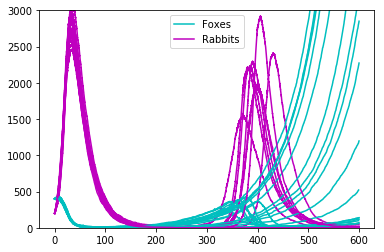

Everything died 5 times out of 300 or 1.7%
Foxes died 221 times out of 300 or 73.7%
Second peak (days) is 422.6 with IQR [405.5 - 435.1] 
Second peak (foxes) is 3289.6 with IQR [2993.0 - 3504.0] 


In [2]:
import random
random.seed(1)

k1 = .015 # growth of rabbits per day
k2 = .00004 # deaths of rabbits per day per foxes
k3 = .0004 # growth of foxes per day per rabbits
k4 = .04 # deaths of foxes per day

def rabbits_and_foxes(r, f):
    """ Function to return new calculations of rabbit / fox birth and death.
            INPUT: 
                Growth / Death Rate Constants (k1,k2,k3,k4)
                r = Rabbit Count for current event
                f = Fox Count for current event    
    """
    rabbit_birth = k1 * r
    rabbit_death = k2 * r * f
    fox_birth = k3 * r * f
    fox_death = k4 * f
    
    return (rabbit_birth, rabbit_death, fox_birth, fox_death)  

iterations = 300
total_days = 600
count = 0
dead_foxes = 0
dead_everything = 0
second_peak_t = []
second_peak_f = []

for i in range(iterations):
    print('.', end = '')
    
    # Steps 1 / 2 in KMC Wikipedia page
    today = 0
    rabbit = 400 
    fox = 200
    
    # Creates empty list variables to be populated later in program
    t = []
    r = []
    f = []
    
    
    while today < total_days:
        t.append(today)
        r.append(rabbit)
        f.append(fox)
        
        # Steps 3 / 4 / 9 in KMC Wikipedia page
        (r_birth, r_death, f_birth, f_death) = rates = rabbits_and_foxes(rabbit,fox)
        total_rate = sum(rates) # Qk, sum of rates
        
        if total_rate == 0:
            dead_everything += 1
            t.append(total_days)
            r.append(rabbit)
            f.append(fox)
            break
        
        wait_time = random.expovariate( total_rate ) # Random step interval
        today += wait_time # Increment variable by random time step
        
        """Step 5 in KMC Wikipedia page.
        
        Generates a number between 0 and rate total
        
        Event probability (highest to lowest):
            1. fox birth
            2. fox death
            3. rabbit birth
            4. rabbit death        
        """ 
        event = random.uniform(0, total_rate)
        
        # Subtracts rate values until an event is identified
        
        rabbit_ded = r_death + r_birth
        fox_baby = rabbit_ded + f_birth
        fox_ded = total_rate
        
        # Steps 6 / 7 in KMC Wikipedia page
        if fox_ded >= event > fox_baby:
            fox -= 1
            if not fox:
                dead_foxes += 1
        elif fox_baby >= event > rabbit_ded:
            fox += 1
        elif rabbit_ded >= event > r_birth:             
            rabbit -= 1
        else:
            rabbit += 1
    
    # Converts lists to arrays for later use
    t = np.array(t)
    r = np.array(r)
    f = np.array(f)
    
    # Calculates index number of second peak of foxes 
    second_peak_location = np.argmax(f)
    
    # Appends list variables if condition is met
    if t[second_peak_location] > 200:
        second_peak_t.append(t[second_peak_location])
        second_peak_f.append(f[second_peak_location])
    
    if i < 20:
        plt.plot(t, r, 'c')
        plt.plot(t, f, 'm')
        
plt.legend(['Foxes','Rabbits'], loc = "best")
plt.ylim(0,3000)
plt.show()

# Calculation of average time / fox counts for second peak
mean_second_peak_t = np.mean(second_peak_t)
mean_second_peak_f = np.mean(second_peak_f)

second_peak_t = np.array(second_peak_t)
second_peak_f = np.array(second_peak_f)

# Calculation of 25% and 75% of each array
quartile_25, quartile_75 = np.percentile(second_peak_t,[25,75])
quartile_25f, quartile_75f = np.percentile(second_peak_f, [25,75])

print("Everything died {} times out of {} or {:.1f}%".format(dead_everything, iterations, 100*dead_everything/iterations))
print("Foxes died {} times out of {} or {:.1f}%".format(dead_foxes, iterations, 100*dead_foxes/iterations))
print("Second peak (days) is {:.1f} with IQR [{:.1f} - {:.1f}] ".format(mean_second_peak_t, quartile_25, quartile_75))
print("Second peak (foxes) is {:.1f} with IQR [{:.1f} - {:.1f}] ".format(mean_second_peak_f, quartile_25f, quartile_75f))

In [3]:
%load_ext line_profiler

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from statistics import stdev

In [8]:
def run_everything():
    import random
    random.seed(1)

    k1 = .015 # growth of rabbits per day
    k2 = .00004 # deaths of rabbits per day per foxes
    k3 = .0004 # growth of foxes per day per rabbits
    k4 = .04 # deaths of foxes per day

    def rabbits_and_foxes(r, f):
        """ Function to return new calculations of rabbit / fox birth and death.
                INPUT: 
                    Growth / Death Rate Constants (k1,k2,k3,k4)
                    r = Rabbit Count for current event
                    f = Fox Count for current event    
        """
        rabbit_birth = k1 * r
        rabbit_death = k2 * r * f
        fox_birth = k3 * r * f
        fox_death = k4 * f

        return (rabbit_birth, rabbit_death, fox_birth, fox_death)  

    iterations = 20
    total_days = 600
    count = 0
    dead_foxes = 0
    dead_everything = 0
    second_peak_t = []
    second_peak_f = []

    for i in range(iterations):
        print('.', end = '')

        # Steps 1 / 2 in KMC Wikipedia page
        today = 0
        rabbit = 400 
        fox = 200

        # Creates empty list variables to be populated later in program
        t = []
        r = []
        f = []


        while today < total_days:
            t.append(today)
            r.append(rabbit)
            f.append(fox)

            # Steps 3 / 4 / 9 in KMC Wikipedia page
            (r_birth, r_death, f_birth, f_death) = rates = rabbits_and_foxes(rabbit,fox)
            total_rate = sum(rates) # Qk, sum of rates

            if total_rate == 0:
                dead_everything += 1
                t.append(total_days)
                r.append(rabbit)
                f.append(fox)
                break

            wait_time = random.expovariate( total_rate ) # Random step interval
            today += wait_time # Increment variable by random time step

            """Step 5 in KMC Wikipedia page.

            Generates a number between 0 and rate total

            Event probability (highest to lowest):
                1. fox birth
                2. fox death
                3. rabbit birth
                4. rabbit death        
            """ 
            event = random.uniform(0, total_rate)

            # Subtracts rate values until an event is identified

            rabbit_ded = r_death + r_birth
            fox_baby = rabbit_ded + f_birth
            fox_ded = total_rate

            # Steps 6 / 7 in KMC Wikipedia page
            if fox_ded >= event > fox_baby:
                fox -= 1
                if not fox:
                    dead_foxes += 1
            elif fox_baby >= event > rabbit_ded:
                fox += 1
            elif rabbit_ded >= event > r_birth:             
                rabbit -= 1
            else:
                rabbit += 1

        # Converts lists to arrays for later use
        t = np.array(t)
        r = np.array(r)
        f = np.array(f)

        # Calculates index number of second peak of foxes 
        second_peak_location = np.argmax(f)

        # Appends list variables if condition is met
        if t[second_peak_location] > 200:
            second_peak_t.append(t[second_peak_location])
            second_peak_f.append(f[second_peak_location])

        if i < 20:
            plt.plot(t, r, 'c')
            plt.plot(t, f, 'm')

    plt.legend(['Foxes','Rabbits'], loc = "best")
    plt.ylim(0,3000)
    plt.show()

    # Calculation of average time / fox counts for second peak
    mean_second_peak_t = np.mean(second_peak_t)
    mean_second_peak_f = np.mean(second_peak_f)

    second_peak_t = np.array(second_peak_t)
    second_peak_f = np.array(second_peak_f)

    # Calculation of 25% and 75% of each array
    quartile_25, quartile_75 = np.percentile(second_peak_t,[25,75])
    quartile_25f, quartile_75f = np.percentile(second_peak_f, [25,75])

    print("Everything died {} times out of {} or {:.1f}%".format(dead_everything, iterations, 100*dead_everything/iterations))
    print("Foxes died {} times out of {} or {:.1f}%".format(dead_foxes, iterations, 100*dead_foxes/iterations))
    print("Second peak (days) is {:.1f} with IQR [{:.1f} - {:.1f}] ".format(mean_second_peak_t, quartile_25, quartile_75))
    print("Second peak (foxes) is {:.1f} with IQR [{:.1f} - {:.1f}] ".format(mean_second_peak_f, quartile_25f, quartile_75f))

....................

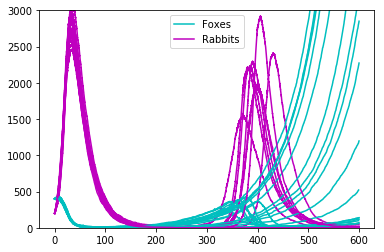

Everything died 0 times out of 20 or 0.0%
Foxes died 13 times out of 20 or 65.0%
Second peak (days) is 405.5 with IQR [405.5 - 405.5] 
Second peak (foxes) is 2919.0 with IQR [2919.0 - 2919.0] 
24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n1 -r1
%lprun -f run_everything run_everything()